In [1]:
using CairoMakie
using Unitful
using NumericalIntegration

#### Generating input
* extinction ($\alpha_\nu$)
* depth ($l$) and height ($z$) scale
* source function $S_\nu$

In [2]:
NWAVE = 101
freq = range(-5., 5., NWAVE)
extinction = (exp.(-freq .^ 2) .+ 0.5 * freq / 50 .+ 0.1) ./ 100u"m"
NDEP = 200
depth = logrange(1, 1e4, NDEP)u"m"
height = -depth .+ maximum(depth)
i_units = u"kW / m^2 * nm * sr"
#source_function = (ustrip(height)) / 100 * i_units  # emission line
source_function = range(0, 500, NDEP) * i_units  # absorption line
extinction = repeat(extinction, outer=(1, NDEP));

## Calculations

### Optical depth
$$
\tau_\nu (z_0) = -\int_\infty^{z_0} \alpha_\nu \mathrm{d}z \;\;\;\; \mathrm{(height\; scale)}
$$

$$
\tau_\nu (l_0) = \int_0^{l_0} \alpha_\nu \mathrm{d}l\;\;\;\; \mathrm{(depth\; scale)}
$$

Note that $z=\infty$ is the same point as $l=0$, and corresponds to the surface of the emitting body (here assumed to have an infinite extent). The $\tau$ integration can be done both ways.

### Emerging intensity

$$
I_\nu(\tau_\nu=0) = \int_0^\infty S_\nu e^{-\tau_\nu}\mathrm{d}\tau_\nu.
$$

In [3]:
tau = zeros(Float64, NWAVE, NDEP)
intensity = zeros(Float64, NWAVE) * i_units

for i in 1:NWAVE
    tau[i, :] = cumul_integrate(-height, extinction[i, :])
    intensity[i] = integrate(tau[i, :], source_function .* exp.(-tau[i, :]))
end

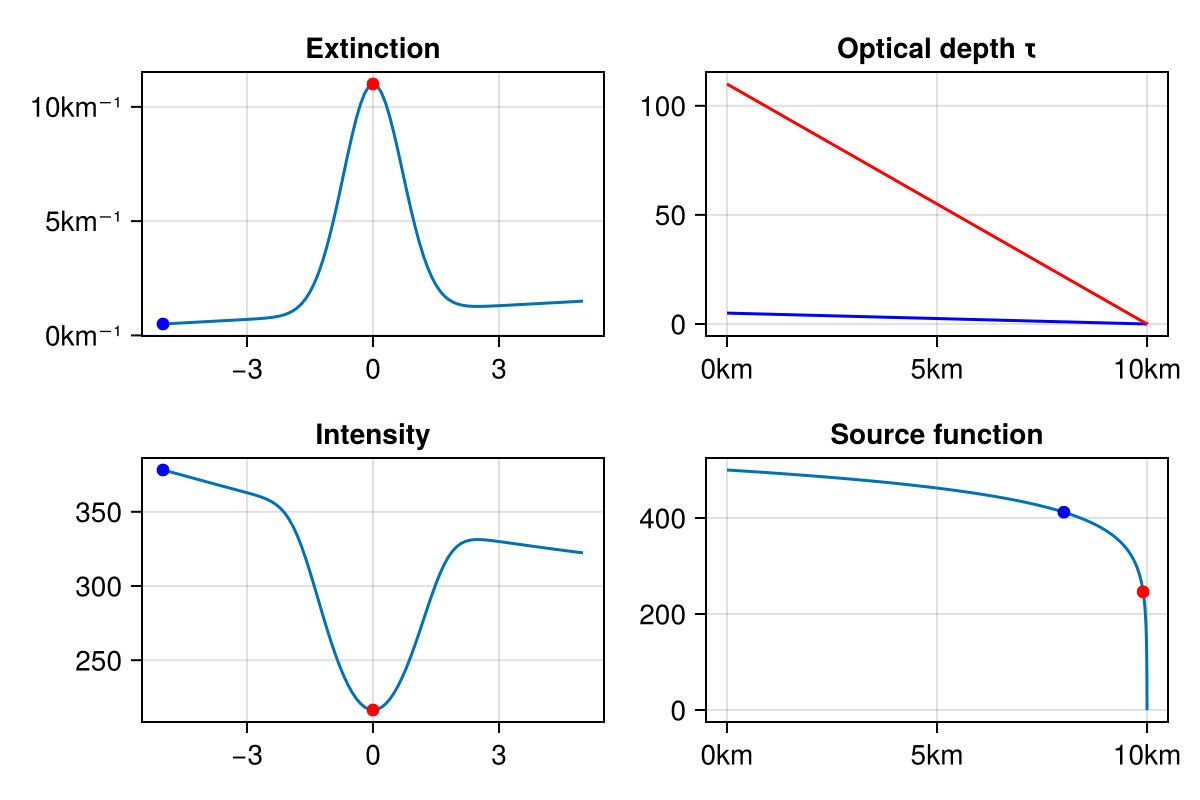

In [4]:
fig = Figure(size=(600,400))
ii = ustrip(intensity)
ss = ustrip(source_function)

ax11 = Axis(fig[1,1], title="Extinction")
lines!(ax11, freq, extinction[:, 1])
scatter!(ax11, [freq[1]], [extinction[1,1]]; color=:blue)
scatter!(ax11, [freq[51]], [extinction[51,1]]; color=:red)

ax12 = Axis(fig[1,2], title="Optical depth τ")
lines!(ax12, height, tau[1, :]; color=:blue)
lines!(ax12, height, tau[51, :]; color=:red)
tau1_1 = argmin(abs.(tau[1, :] .- 1))
tau1_51 = argmin(abs.(tau[51, :] .- 1))

ax21 = Axis(fig[2,1], title="Intensity")
lines!(ax21, freq, ii)
scatter!(ax21, [freq[1]], [ii[1]]; color=:blue)
scatter!(ax21, [freq[51]], [ii[51]]; color=:red)

ax22 = Axis(fig[2,2], title="Source function")
lines!(ax22, height, ss)
scatter!(ax22, [height[tau1_1]], [ss[tau1_1]]; color=:blue)
scatter!(ax22, [height[tau1_51]], [ss[tau1_51]]; color=:red)

fig